In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import shap
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

In [2]:
train_df = pd.read_csv("Tables/bnpl_train.csv")
test_df = pd.read_csv("Tables/bnpl_test.csv")
val_df = pd.read_csv("Tables/bnpl_val.csv")
target_col = "default_flag"

In [3]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(), test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 14) (199, 14) (199, 14)
   external_repayment_loans  credit_card_interest_incidence  default_flag  \
0                         1                               0             0   
1                         0                               0             0   
2                         0                               0             0   
3                         0                               1             0   
4                         1                               1             0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buyi

In [4]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())



X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [5]:
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())

X_test shape: (199, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         0                               0   
1                         0                               1   
2                         1                               0   
3                         0                               0   
4                         0                               0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0              0.180572               -0.890977                  0.005600   
1             -1.413380                1.594809                  1.643651   
2              1.546817                0.174360                 -1.670546   
3             -1.413380               -0.180752                 -1.327698   
4             -0.047135                0.529472                  1.567463   

   payment_delinquency_count  impulsive_buying_score  \
0                   1.462180                0.504892   
1                  -0.

In [6]:
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_val shape: (199, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         0                               1   
1                         0                               0   
2                         0                               0   
3                         1                               0   
4                         0                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.502550                1.239697                  0.272259   
1              0.408279               -0.535864                 -1.670546   
2              0.635987               -0.890977                  0.043694   
3             -0.730258                0.884585                 -0.108683   
4              0.635987                0.529472                 -0.337248   

   payment_delinquency_count  impulsive_buying_score  \
0                  -0.907642                0.160491   
1                   1.4

In [7]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


default_flag
0    0.922689
1    0.077311
Name: proportion, dtype: float64
default_flag
0    0.919598
1    0.080402
Name: proportion, dtype: float64
default_flag
0    0.919598
1    0.080402
Name: proportion, dtype: float64


Model

In [8]:
rf = RandomForestClassifier(
    n_estimators=100,      # start with 100 trees
    max_depth=None,        # let trees grow until leaves are pure
    random_state=42,       # for reproducibility
    n_jobs=-1              # use all CPU cores
)

In [9]:
# Fit the model
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
# Class labels
y_valid_pred = rf.predict(X_val)

# Predicted probabilities for the positive class (default)
y_valid_proba = rf.predict_proba(X_val)[:, 1]

In [11]:

# Define thresholds to evaluate
thresholds = np.arange(0.0, 1.01, 0.01)

# Find the threshold that maximizes F1 score
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_valid_pred_thresh = (y_valid_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_valid_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Use the best threshold for predictions
y_valid_pred_thresh = (y_valid_proba >= best_threshold).astype(int)

# Print the best threshold and F1 score
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")

Best Threshold: 0.37
Best F1 Score: 1.0


In [12]:
y_valid_pred_thresh = (y_valid_proba >= best_threshold).astype(int)

In [13]:
# 3. Recompute your evaluation
print(f"--- Metrics at best threshold for f1 score = {best_threshold} ---\n")
print("Classification Report:\n", classification_report(y_val, y_valid_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_valid_pred_thresh))
print("ROC AUC Score:   ", roc_auc_score(y_val, y_valid_proba))
print("F1 Score:        ", f1_score(y_val, y_valid_pred_thresh))
print("Recall Score:    ", recall_score(y_val, y_valid_pred_thresh))
print("Precision Score: ", precision_score(y_val, y_valid_pred_thresh))

--- Metrics at best threshold for f1 score = 0.37 ---

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       183
           1       1.00      1.00      1.00        16

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199

Confusion Matrix:
 [[183   0]
 [  0  16]]
ROC AUC Score:    1.0
F1 Score:         1.0
Recall Score:     1.0
Precision Score:  1.0


In [14]:
#get the best features that explain default
feature_names = X_train.columns
importances = rf.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                           Feature  Importance
11                 bnpl_debt_ratio    0.166664
2             bnpl_usage_frequency    0.152238
12        stress_usage_interaction    0.143242
3           financial_stress_score    0.137060
5        payment_delinquency_count    0.120387
4         credit_limit_utilisation    0.095528
8         debt_accumulation_metric    0.052946
6           impulsive_buying_score    0.035696
7    financial_literacy_assessment    0.032492
10         demographic_risk_factor    0.023358
9         return_dispute_incidents    0.022428
0         external_repayment_loans    0.010179
1   credit_card_interest_incidence    0.007782


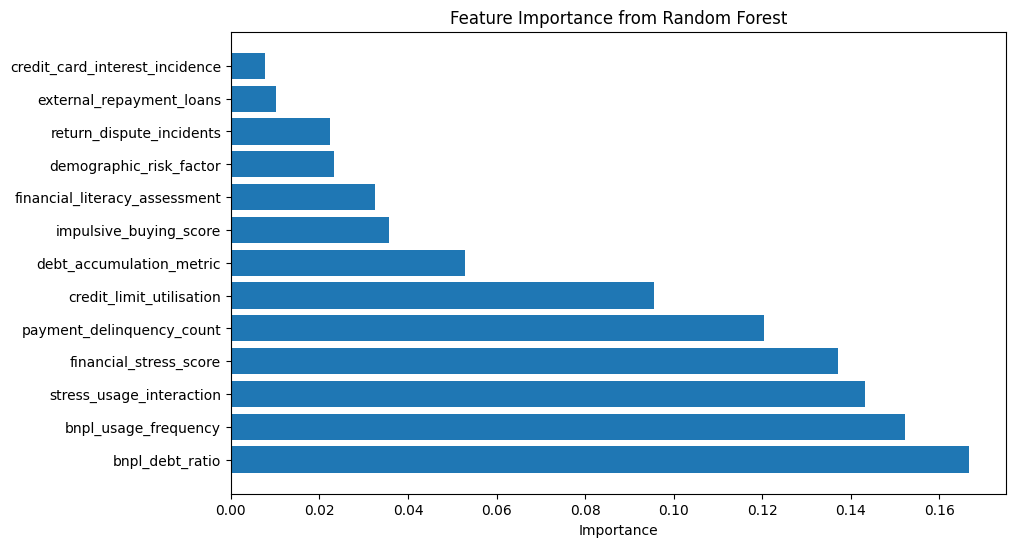

In [40]:
#plot the feature importance using a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

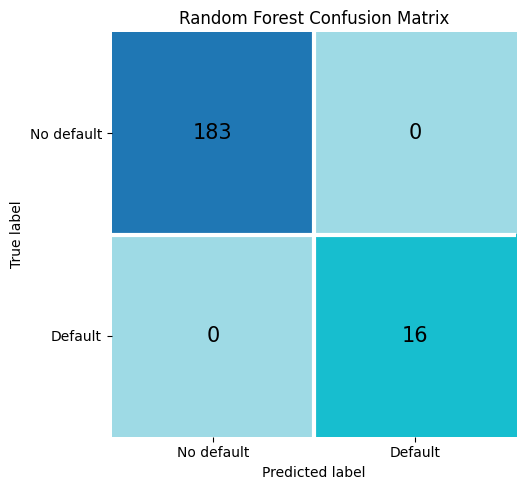

In [14]:

# Raw counts
cm = confusion_matrix(y_val, y_valid_pred_thresh, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])

# Plot with custom settings
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(values_format='d', cmap='tab20_r', ax=ax, colorbar=0)

# Make the numbers bigger
for text in disp.text_.ravel():   # text_ stores the annotation objects
    text.set_fontsize(15)
    text.set_color('black')  # Set text color to black for better visibility
n_classes = cm.shape[0]
for i in range(1, n_classes):  
    ax.axhline(i - 0.5, color='white', linewidth=3)  # horizontal line
    ax.axvline(i - 0.5, color='white', linewidth=3)  # vertical line
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.savefig("Plots/Confusion Matricies/Random_Forest_cm.png")
plt.show()

In [15]:

fpr, tpr, thresholds = roc_curve(y_val, y_valid_proba)

results = {
    "threshold": best_threshold,
    "confusion_matrix": confusion_matrix(y_val, y_valid_pred_thresh).tolist(),  # convert to list for saving
    "accuracy": accuracy_score(y_val, y_valid_pred_thresh),
    "precision": precision_score(y_val, y_valid_pred_thresh),
    "recall": recall_score(y_val, y_valid_pred_thresh),
    "f1_score": f1_score(y_val, y_valid_pred_thresh),
    "roc_auc": roc_auc_score(y_val, y_valid_pred_thresh),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),
}
with open("Results/RF_model_results.json", "w") as f:
    json.dump(results, f)